<a href="https://colab.research.google.com/github/b-mi/colab/blob/main/cvicenie2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from tools import *

In [ ]:
data = pd.read_csv('./datasets/iris.csv')
print(data.head())

   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa


In [ ]:
# spocitam stvorce, a tiez aby som mal v datach dva udaje pre suradnice grafu
data['sepal_square'] = data.SepalLengthCm * data.SepalWidthCm
data['petal_square'] = data.PetalLengthCm * data.PetalWidthCm


In [ ]:
#dropnem zbytocnosti, nech SVM nezblbne
data.drop('Id', axis='columns', inplace=True)
data.drop('SepalLengthCm', axis='columns', inplace=True)
data.drop('SepalWidthCm', axis='columns', inplace=True)
data.drop('PetalLengthCm', axis='columns', inplace=True)
data.drop('PetalWidthCm', axis='columns', inplace=True)


In [ ]:
#normalizovat inputy
normalize_columns(data, ['sepal_square',  'petal_square'])

In [ ]:
# rozdelit data na normalizovane inputy a targety
y, X = np.split(data, [1], axis=1)
#print(X)
#print(y)

In [ ]:
# rozdelit data na train a test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
#print('X_train\n', X_train)
#print('y_train\n', y_train)
#print('X_test\n', X_test)
#print('t_test\n', y_test)
#print(data)

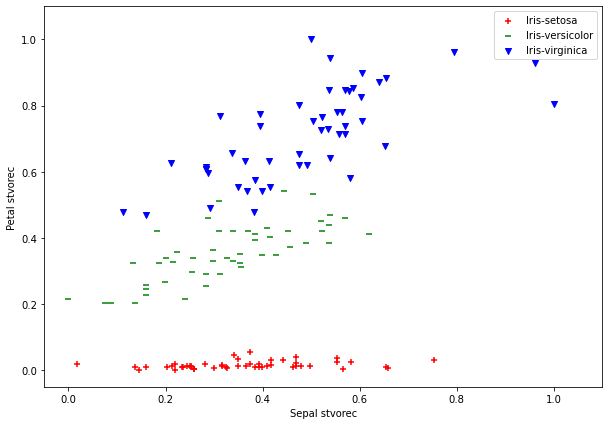

In [ ]:
# prve malovanie
def plot_svm(dataset, clf=None, text=None):
    fig = plt.figure(figsize=(10, 7))
    names = [
        ('Iris-setosa', 'r', '+'), 
        ('Iris-versicolor', 'g', '_'), 
        ('Iris-virginica', 'b', 'v')]
    
    for item in names:
        name, colr, mark = item
        ds = dataset.loc[data['Species'] == name]
        pos_x = ds.to_numpy()[:, 1]
        pos_y = ds.to_numpy()[:, 2]
        plt.scatter(pos_x, pos_y, color=colr, marker=mark, label=name)

    #zial tu vyhadzuje chybu, ktoru na zaklade chyboveho oznamu neviem vyriesit
    if clf:
        xx = np.linspace(0, 1, 30)
        yy = np.linspace(0, 1, 30)
        YY, XX = np.meshgrid(yy, xx)
        xy = np.vstack([XX.ravel(), YY.ravel()]).T
        Z = clf.decision_function(xy).reshape(XX.shape)

        # decision boundary
        plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1],
        linestyles=["--", "-", "--"])
        
        # support vectors
        if hasattr(clf, "support_vectors_"):
            plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                       s=100, linewidth=1, facecolors="none", edgecolors="k")
        
        
        
    plt.ylim(top=1.1)
    plt.xlim(right=1.1)
    
    plt.xlabel('Sepal stvorec')
    plt.ylabel('Petal stvorec')
    plt.legend()
    
    if text:
        plt.text(0.02,0.12, text, ha="left", va="center")
    
    plt.show()
    return fig

fig1 = plot_svm(data)

ValueError: cannot reshape array of size 2700 into shape (30,30)

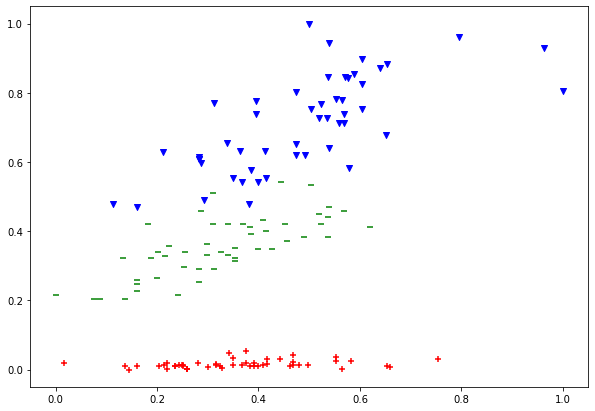

In [ ]:
# hunting for idealne parametre
svc = SVC()
params = [
    #{'kernel': ['poly'], 'C': [1, 3, 5, 10, 25, 100], 'degree': [1, 2, 3], 'gamma': [.1, .5, 2, 10]},
    {'kernel': ['rbf'],  'C': [1, 3, 5, 8, 10, 12, 14, 16, 18, 20, 22,  25],                      'gamma': [.1, .3, .5, 1, 2, 3, 4, 5]},
    #{'kernel': ['sigmoid'], 'C': [1, 25, 100], 'gamma': [.1, .7, 1, 5, 10], 'coef0': [.1, .7, 2, 5, 10]}    
]
# kernel poly a sigmoid nedava lepsie riesenie ako rbf, preto som ich zapoznamkoval

clf = GridSearchCV(estimator=svc, param_grid=params, cv = 4)
clf.fit(X_train, y_train.to_numpy().ravel())
scores = clf.score(X_test, y_test.to_numpy().ravel())
best = clf.best_params_

# prepocet z dovodu aby to vykreslilo support body
clf2 = SVC(kernel=best['kernel'], C=best['C'], gamma=best['gamma'])
clf2.fit(X_test, y_test.to_numpy().ravel())
fig1 = plot_svm(data, clf2, 'Model ma presnost: {:0.2%} (+/- {:0.2%} odchylka), best: {}'.format(scores.mean(), scores.std(), clf.best_params_))


In [ ]:
#zaverecne poznamky
# - zvoleny kernel - lepsie ako GridSearchCV ho nevyberiem, ale vzhladom k tomu ze data su jasne, tak dobry vysledok dava kazdy kernel
# - presnost to ukazuje 94% (obcas aj 98%), ukazovalo mi to povodne aj odchylku, neskor uz vzdy nulu, neviem preco
# - nedava to snad uplne hausnumera

# poprosil by som pomoct s problemom plot_svm, kde je zapoznamovana cast kodu ktora mala kreslit tie hranice, je tam ale chyba ktoru nviem vyriesit. Vdaka.